Przygotowywujemy i ladujemy dane do zmiennych

In [19]:
# pip install -U pandas
import pandas
# pip install -U spacy
# python -m spacy download pl_core_news_sm
import spacy

# pip install -U matplotlib
import matplotlib.pyplot as plt


# Load Polish tokenizer, tagger, parser and NER
nlp = spacy.load("pl_core_news_sm")
# https://exp.lobi.nencki.gov.pl/nawl-analysis
nawl = pandas.read_csv('nawl-analysis.csv')
lista_mowiacych= pandas.read_excel("Lista mówiących.xlsx")


bierzemy liste unikalnych kodow osob z listy mowiacych

In [20]:
osoby = lista_mowiacych['Kod osoby'].unique()

pobieramy teksty danej osoby pozbywamy sie dodatkowych tagow z transkrypcji i znaków specjalnych takich jak przecinki i kropki

In [21]:
import re
def getTextFromPerson(person):
    with open('./Dane/'+person+'.wav-16k.wav.txt',"r",encoding='utf-8') as file:
        #usuniecie dodatkowych tagow z transkrypcji
        striped=re.sub(r'(\[_BEG_\]\W)|(\[_TT_\d*\])|\[oklaski\]','',file.read())
        normalized=re.sub(r'\.|\,|\n','',striped).strip()
        return normalized.lower()
# print(getTextFromPerson('5EF9'))

uzywajac spacy parsujemy i lemmatyzujemy teksty (dodatkowo pozbywamy się elementów takich jak 'być' w celu lepszego dopasowania do NAWL)

In [22]:
def getAnalysisFromTextList(text):
    doc = nlp(text)
    # nouns=[token.lemma_ for token in doc if token.pos_ == "NOUN"]
    nouns=[re.sub(r'\Wbyć','',token.lemma_) for token in doc if token.pos_ == "NOUN"]
    # verbs=[token.lemma_ for token in doc if token.pos_ == "VERB"]
    verbs=[re.sub(r'\Wbyć','',token.lemma_) for token in doc if token.pos_ == "VERB"]
    return nouns+verbs
# print(getAnalysisFromTextList(getTextFromPerson('5EF9')))


Z utworzonej analizy tworzymy tabelke osoba i slowo

In [23]:
data = [(code,word)  for code in osoby for word in getAnalysisFromTextList(getTextFromPerson(code))]
wordsDataFrame = pandas.DataFrame({'Kod osoby':[code for (code,word) in data],'word':[word for (_,word)in data]})
# print(data)
# print(wordsDataFrame)

Laczymy ja na potrzeby analizy z naszą baza dancyh mówiacych

In [24]:
lista_z_slowami=pandas.merge(wordsDataFrame,lista_mowiacych,how='left',on='Kod osoby')
# print(lista_z_slowami)


laczymy nasze zebrane slowa z baza danych nawl na podstawie slow

In [25]:
data_with_nawl=pandas.merge(lista_z_slowami,nawl,how='left',on='word')


Usuwamy elementy tabelki z pustymi wartosciami (nie znalezlismy dla nich dopasowania)

In [26]:
data=data_with_nawl.dropna()
print(data)

     Kod osoby       word   Debata           Drużyna      Strona     Rola  \
0         5EF9      osoba  Debata1    Druga opozycja    Opozycja  Mówca 1   
2         5EF9      mówić  Debata1    Druga opozycja    Opozycja  Mówca 1   
5         5EF9    telefon  Debata1    Druga opozycja    Opozycja  Mówca 1   
6         5EF9    telefon  Debata1    Druga opozycja    Opozycja  Mówca 1   
7         5EF9       ręka  Debata1    Druga opozycja    Opozycja  Mówca 1   
...        ...        ...      ...               ...         ...      ...   
4155      ZUZ9     chcieć  Debata1  Druga propozycja  Propozycja  Mówca 2   
4157      ZUZ9    należeć  Debata1  Druga propozycja  Propozycja  Mówca 2   
4160      ZUZ9        móc  Debata1  Druga propozycja  Propozycja  Mówca 2   
4168      ZUZ9   podnosić  Debata1  Druga propozycja  Propozycja  Mówca 2   
4171      ZUZ9  dziękować  Debata1  Druga propozycja  Propozycja  Mówca 2   

     category  mean Happiness  mean Anger  mean Sadness  mean Fear  \
0    

tlumaczymy kolumny na polski w celu wyświetlenia

In [27]:
data = data.rename(columns={
      "mean Anger": "Złość",
      "mean Sadness": "Smutek",
      'mean Happiness':"Radość",
      'mean Fear':"Strach",
      'mean Disgust':"Wstręt"
    })

In [28]:
# przykladowe filtrowanie danych
# print(data)
# print(data[data['Kod osoby']=='7JU8'])
# print(data.groupby('Debata')[['Radość','Złość','Smutek','Strach','Wstręt']].mean())
# print(data.groupby('Strona')[['Radość','Złość','Smutek','Strach','Wstręt']].mean())
# print(data[data['Debata']=='Debata1'].groupby('word')['word'].count())

funkcja wyświetlajaca dane na wykresie:

In [29]:
def displayEmotionMeansPlot(dataFrame):
    fig, ax2 = plt.subplots()
    mean=dataFrame[['Radość','Złość','Smutek','Strach','Wstręt']].mean()
    # print(debata2_mean)
    mean.plot(kind='bar',ax=ax2,rot=0,grid=True)
    ax2.grid(axis='x')
    ax2.set(axisbelow=True)
    plt.show()


In [30]:
# displayEmotionMeansPlot(data.groupby('Debata'))

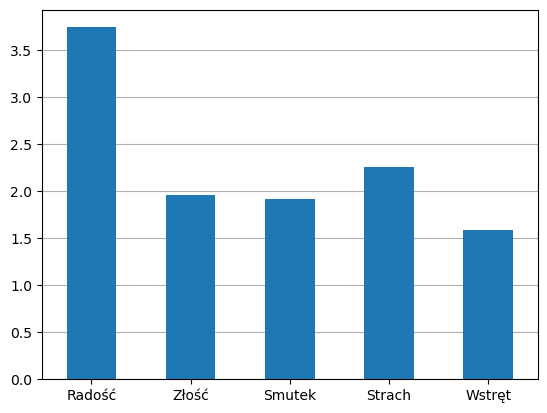

In [31]:

displayEmotionMeansPlot(data[data['Debata']=='Debata1'])

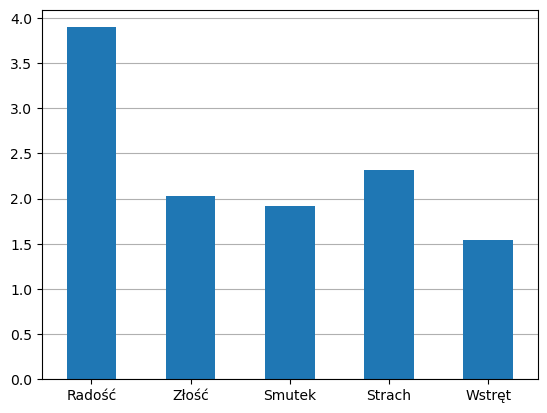

In [32]:
displayEmotionMeansPlot(data[data['Debata']=='Debata2'])

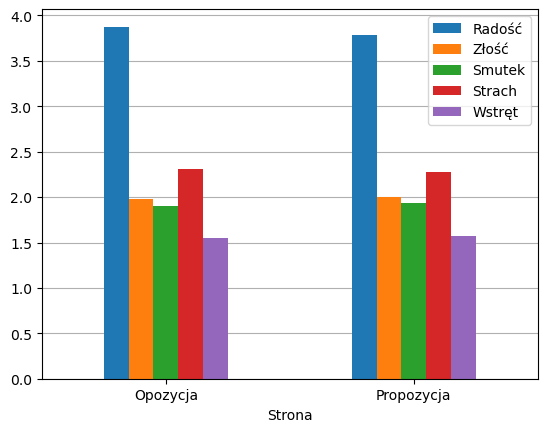

In [33]:
displayEmotionMeansPlot(data.groupby("Strona"))


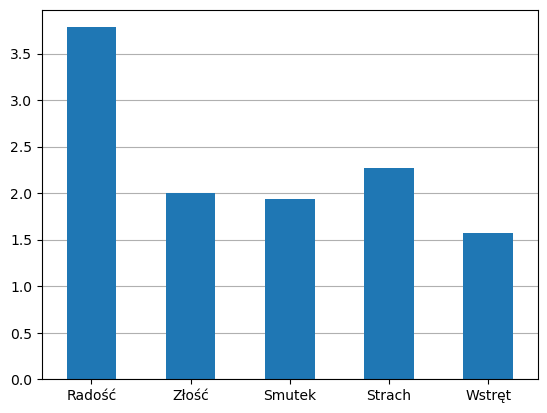

In [34]:
displayEmotionMeansPlot(data[data['Strona']=='Propozycja'])

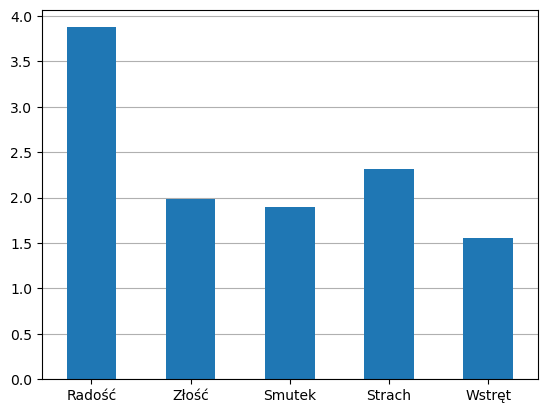

In [35]:
displayEmotionMeansPlot(data[data['Strona']=='Opozycja'])